In [1]:
import numpy as np
import pyvista as pv

import k3d
from k3d.colormaps.basic_color_maps import Rainbow
from k3d.colormaps import paraview_color_maps

from IPython.display import clear_output
import time

#from sympy import *
import math

In [2]:
def viewer_objs(particle_pos,world_bounds=None):
    #a simple viewer to visulize particles

    #Add points to plot
    num_pts = len(particle_pos)
    pkts = k3d.points(particle_pos.astype(np.float32))
    pkts.shader="mesh"

    #Add bounding box to plot
    if world_bounds is not None:
        lower,upper = np.array(world_bounds[0:3]),np.array(world_bounds[3:6])
        size = upper-lower
        cube_pv = pv.Cube(center=(lower+upper)/2.0,x_length=size[0],y_length=size[1],z_length=size[2])
        bbox = k3d.vtk_poly_data(cube_pv,
                                    color=0x000000,
                                    #opacity=0.5,
                                    wireframe=True)

    return pkts,bbox

def plot_particles(pos, world_bounds=[]):
    plot_pts,plot_box = viewer_objs(pos,world_bounds=world_bounds)
    plot_pts.point_size = 0.002
    plot_pts.attribute = pos[:,2]
    plot_pts.color_range=[0.0,np.max(plot_pts.attribute)]
    plot_pts.color_map = paraview_color_maps.Erdc_rainbow_dark

    plot = k3d.plot()
    plot += plot_pts
    plot += plot_box
    plot.display()

    return plot_pts

## Particle tracking to solve solute transport equation at macro-scale  (molecular diffusion + pore-scale dispersion)


Solute transport equation:

$$
\frac{\partial c_i}{\partial t}=-\mathbf{u}\cdot \nabla c_i+\nabla \cdot \left( D\nabla c_i \right) 
$$

Solve above equation in Lagrangian domain:
$$
\mathbf{x}\left( t^{n+1} \right) =\mathbf{x}\left( t^n \right) +\mathbf{u}\left( \mathbf{x}\left( t^n \right) ,t^n \right) \varDelta t+\mathbf{B}\cdot \xi \left( t \right) \sqrt{\Delta t}
$$

Given $\mathbf{B}$ is a 3x3 matrix that includes molecular diffusion and dispersion, and konws $2\mathbf{D}\left( \mathbf{x}\left( t^n \right) \right) =\mathbf{B}\left( \mathbf{x}\left( t^n \right) \right) \cdot \mathbf{B}^T\left( \mathbf{x}\left( t^n \right) \right) $

The general expression of $\mathbf{D} = \mathbf{D}=\left( \alpha _T\left| \mathbf{u} \right|+D_m \right) \mathbf{I}+\frac{\alpha _L-\alpha _T}{\left| \mathbf{u} \right|}\mathbf{uu}^T$   considering pore-scale dispersion are:
$$
\mathbf{D}=\left[ \begin{matrix}
	\left( \alpha _T\left| \mathbf{u} \right|+D_m \right) +\left( \alpha _L-\alpha _T \right) \frac{u_{1}^{2}}{\left| \mathbf{u} \right|}&		\left( \alpha _L-\alpha _T \right) \frac{u_1u_2}{\left| \mathbf{u} \right|}&		\left( \alpha _L-\alpha _T \right) \frac{u_1u_3}{\left| \mathbf{u} \right|}\\
	\left( \alpha _L-\alpha _T \right) \frac{u_1u_2}{\left| \mathbf{u} \right|}&		\left( \alpha _T\left| \mathbf{u} \right|+D_m \right) +\left( \alpha _L-\alpha _T \right) \frac{u_{2}^{2}}{\left| \mathbf{u} \right|}&		\left( \alpha _L-\alpha _T \right) \frac{u_2u_3}{\left| \mathbf{u} \right|}\\
	\left( \alpha _L-\alpha _T \right) \frac{u_1u_3}{\left| \mathbf{u} \right|}&		\left( \alpha _L-\alpha _T \right) \frac{u_2u_3}{\left| \mathbf{u} \right|}&		\left( \alpha _T\left| \mathbf{u} \right|+D_m \right) +\left( \alpha _L-\alpha _T \right) \frac{u_{3}^{2}}{\left| \mathbf{u} \right|}\\
\end{matrix} \right] 
$$

Expression of $\mathbf{B}$ from Eq.64 of `doi.org/10.1029/2000WR000100`  are given in
$$
\mathbf{B}=\left[ \begin{matrix}
	\frac{u_1}{\left| \mathbf{u} \right|}\sqrt{\alpha _L\left| \mathbf{u} \right|+D_m}&		-\frac{u_1u_3\sqrt{\alpha _T\left| \mathbf{u} \right|+D_m}}{\left| \mathbf{u} \right|\sqrt{u_{1}^{2}+u_{2}^{2}}}&		-\frac{u_2\sqrt{\alpha _T\left| \mathbf{u} \right|+D_m}}{\sqrt{u_{1}^{2}+u_{2}^{2}}}\\
	\frac{u_2}{\left| \mathbf{u} \right|}\sqrt{\alpha _L\left| \mathbf{u} \right|+D_m}&		-\frac{u_2u_3\sqrt{\alpha _T\left| \mathbf{u} \right|+D_m}}{\left| \mathbf{u} \right|\sqrt{u_{1}^{2}+u_{2}^{2}}}&		\frac{u_1\sqrt{\alpha _T\left| \mathbf{u} \right|+D_m}}{\sqrt{u_{1}^{2}+u_{2}^{2}}}\\
	\frac{u_3}{\left| \mathbf{u} \right|}\sqrt{\alpha _L\left| \mathbf{u} \right|+D_m}&		\sqrt{\frac{u_{1}^{2}+u_{2}^{2}}{\left| \mathbf{u} \right|^2}\alpha _T\left| \mathbf{u} \right|+D_m}&		0\\
\end{matrix} \right] 
$$

Expression of $\mathbf{B}$ from Eq.11 of `doi.org/10.1016/j.cpc.2019.01.0130010-4655`  are given in:
https://github.com/GerryR/par2/blob/1b7ebffa0c494339e01bd12edbfb8623da42725e/Geometry/CornerField.cuh#L413
$$
\mathbf{v}_1=\left[ u_1,u_2,u_3 \right] ^T
\\
\mathbf{v}_2=\left[ -u_2,u_1,0 \right] ^T
\\
\mathbf{v}_3=\left[ -u_3u_1,-u_3u_2,u_{1}^{2}+u_{2}^{2} \right] ^T
$$


Expression of $\mathbf{B}$ 
$$
\left[ \begin{matrix}
	\frac{\sqrt{2}\left( u_{1}^{2}\sqrt{D_m+\alpha _L\left| u \right|}+u_{2}^{2}\sqrt{D_m+\alpha _T\left| u \right|}+u_{3}^{2}\sqrt{D_m+\alpha _T\left| u \right|} \right)}{\left| u \right|^2}&		\frac{\sqrt{2}u_1u_2\left( \sqrt{D_m+\alpha _L\left| u \right|}-\sqrt{D_m+\alpha _T\left| u \right|} \right)}{\left| u \right|^2}&		\frac{\sqrt{2}u_1u_3\left( \sqrt{D_m+\alpha _L\left| u \right|}-\sqrt{D_m+\alpha _T\left| u \right|} \right)}{\left| u \right|^2}\\
	\frac{\sqrt{2}u_1u_2\left( \sqrt{D_m+\alpha _L\left| u \right|}-\sqrt{D_m+\alpha _T\left| u \right|} \right)}{\left| u \right|^2}&		\frac{\sqrt{2}\left( u_{1}^{2}\sqrt{D_m+\alpha _T\left| u \right|}+u_{2}^{2}\sqrt{D_m+\alpha _L\left| u \right|}+u_{3}^{2}\sqrt{D_m+\alpha _T\left| u \right|} \right)}{\left| u \right|^2}&		\frac{\sqrt{2}u_2u_3\left( \sqrt{D_m+\alpha _L\left| u \right|}-\sqrt{D_m+\alpha _T\left| u \right|} \right)}{\left| u \right|^2}\\
	\frac{\sqrt{2}u_1u_3\left( \sqrt{D_m+\alpha _L\left| u \right|}-\sqrt{D_m+\alpha _T\left| u \right|} \right)}{\left| u \right|^2}&		\frac{\sqrt{2}u_2u_3\left( \sqrt{D_m+\alpha _L\left| u \right|}-\sqrt{D_m+\alpha _T\left| u \right|} \right)}{\left| u \right|^2}&		\frac{\sqrt{2}\left( u_{1}^{2}\sqrt{D_m+\alpha _T\left| u \right|}+u_{2}^{2}\sqrt{D_m+\alpha _T\left| u \right|}+u_{3}^{2}\sqrt{D_m+\alpha _L\left| u \right|} \right)}{\left| u \right|^2}\\
\end{matrix} \right] 
$$


In [3]:
def initBox(NumPts=10,lower=[0.0,0.0,0.0],size=[1.0,1.0,1.0]):
    """ Generate random points within a box

    pos_box = lower + rand(0,1)*size
          
    Arguments
    ---------
    NumPts       -- Number of points
    lower,size   -- lower coord of the box, size of the box

    Return
    --------
    pos_box [NumPts,3]  -- random pos coords generated
    
    Author:Bin Wang(binwang.0213@gmail.com)
    Date: June, 2022
    """
    pos_box = np.zeros([NumPts,3])
    for i in range(NumPts):
        pos_box[i,:] = lower + np.random.rand(3)*size

    return pos_box  

def calcB(u1,u2,u3,D_m,alpha_T,alpha_L):
    #return ImmutableDenseMatrix([[math.sqrt(2)*(u1**2*math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) + u2**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)) + u3**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), math.sqrt(2)*u1*u2*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), math.sqrt(2)*u1*u3*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2)], [math.sqrt(2)*u1*u2*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), math.sqrt(2)*(u1**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)) + u2**2*math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) + u3**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), math.sqrt(2)*u2*u3*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2)], [math.sqrt(2)*u1*u3*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), math.sqrt(2)*u2*u3*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), math.sqrt(2)*(u1**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)) + u2**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)) + u3**2*math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2)]])
    return np.array(
    [
    [math.sqrt(2)*(u1**2*math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) + u2**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)) + u3**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2),
    math.sqrt(2)*u1*u2*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2),
    math.sqrt(2)*u1*u3*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2)], 
    [math.sqrt(2)*u1*u2*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2),
    math.sqrt(2)*(u1**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)) + u2**2*math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) + u3**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), 
    math.sqrt(2)*u2*u3*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2)], 
    [math.sqrt(2)*u1*u3*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), 
    math.sqrt(2)*u2*u3*(math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)) - math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2), 
    math.sqrt(2)*(u1**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)) + u2**2*math.sqrt(D_m + alpha_T*math.sqrt(u1**2 + u2**2 + u3**2)) + u3**2*math.sqrt(D_m + alpha_L*math.sqrt(u1**2 + u2**2 + u3**2)))/(u1**2 + u2**2 + u3**2)]
    ])

def calcD(B):
    return np.dot(B,B.T)*(0.5)

def dispersion(NumPts, dT, u, alphaL, Dm, alphaT):
    """ Generate random displacement governed by dispersion

    disp = rand(mean=0,std=1.0)*sqrt(dT)*B
          
    Arguments
    ---------
    alphaL  --  transverse to longitudinal dispersitivity
    alphaT  --  vertical to longitudinal dispersitivity
    B       --  dispersion coefficient
    Dm      --  diffusion coefficient
    dT      --  timestep
    u       --  particle velocity

    Return
    --------
    disp [NumPts,3]  -- random displacment generated
    
    Author:ZHOU
    Date: June, 2022
    """
    disp = np.zeros([NumPts,3])
    

    for i in range(NumPts):
        xi = np.random.normal(loc=0.0,scale=1.0,size=3)
        #X=Matrix(xi)
        u1=u[i,0] 
        u2=u[i,1]
        u3=u[i,2]
        
        B=calcB(u1=u1,u2=u2,u3=u3,D_m=Dm,alpha_T=alphaT,alpha_L=alphaL)
    
        #print((xi.T*B)*np.sqrt(dT))
        disp[i,:] = np.dot(xi,B)*np.sqrt(dT)

    return disp

def velocity_field(x,y,z):
    """ The velocity field is held constant in the diagonal direction from bottom left to top right

        : https://www.researchgate.net/publication/285997495

    Arguments
    ---------
    x,y,z      -- query velocity location

    Return
    --------
    vel      -- velocity @ (x,y,z)

    Author:Bin Wang(binwang.0213@gmail.com)
    Date: June, 2022
    """

    vel = np.ones([NumPts,3])

    return vel

def advection(u,dT):
    """ Generate advection displacment 

    disp = u(x,y,z)*dT
          
    Arguments
    ---------
    dT   -- timestep

    Return
    --------
    disp [NumPts,3]  -- advection displacment generated
    
    Author:Bin Wang(binwang.0213@gmail.com)
    Date: June, 2022
    """
    disp = np.zeros([NumPts,3])
    for i in range(NumPts):
        disp[i,:] = u[i,:]*dT
    return disp

In [4]:

# number of particles
NumPts = 500
# timestep for simulation
dt = 0.1  #day
# positions of particles
pos = initBox(NumPts=NumPts,lower=[0,0,0], size=[1,1,1])
# diffusion coefficient
Dm = 0.001
# velocity of particles
vel = np.ones([NumPts,3])
# transverse to longitudinal dispersitivity
aT = 0.005
# vertical to longitudinal dispersitivity
aL = 0.005

In [6]:
SimTime = 0.0
NumSteps = 1000
for ti in range(NumSteps):
    
    #advectin step
    #uz = compute_vel_sqrDuct(dP=dp,miu=mu,h=h,L=L_pipe, x=pos[:,0],y=pos[:,1],z=pos[:,2])
    #vel[:,2]=uz
    
    pos = pos + advection(u=vel,dT=dt)
    
    #dispersion step
    pos = pos + dispersion(NumPts=NumPts, dT=dt, Dm=Dm, u=vel, alphaL=aL, alphaT=aT)
    #print(dispersion(NumPts=NumPts, dT=dt, Dm=Dm, u=vel, alphaL=aL, alphaT=aT))

    #animation
    plot_pts.positions = pos
    plot_pts.attribute = pos[:,0]
    plot_pts.color_range=[0.0,np.max(plot_pts.attribute)]
    time.sleep(0.01)

    SimTime += dt

#print('Simulation Time=',time,'secs')

In [5]:
plot_pts=plot_particles(pos,world_bounds=[0.0,0.0,0.0, 100.0, 100.0, 100.0])
plot_pts.point_size=1

g:\Anaconda\azml\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

Analytical solution: https://doi.org/10.3133/pp411A

Reference: https://www.researchgate.net/publication/285997495

$$
C\left( x,y,z,t \right) =\frac{C_0V}{8\left( \pi t \right) ^{1.5}\sqrt{D_{xx}D_{yy}D_{zz}}}\exp \left[ -\frac{\left( x-x_0 \right) ^2}{4D_{xx}t}-\frac{\left( y-y_0 \right) ^2}{4D_{yy}t}-\frac{\left( z-z_0 \right) ^2}{4D_{zz}t} \right] 
$$


C:\Users\pc\AppData\Local\Temp/ipykernel_195016/3952875681.py:27: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = plt.contour(X, Y, calc_C(X,Y), 6, colors='black', linewidth=.5)


<a list of 6 text.Text objects>

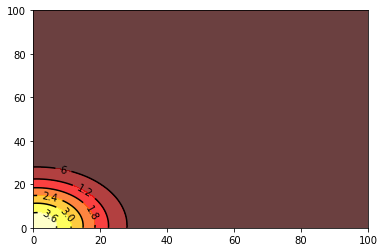

In [7]:

import numpy as np
import matplotlib.pyplot as plt
from numpy.ma import exp


C_0 = 1.0                                                        # the initial concentration = 1 kgm^-3
V = math.sqrt(3)                                                 # velocity field 
B=calcB(u1=1,u2=1,u3=1,D_m=Dm,alpha_T=aT,alpha_L=aL)
D=np.dot(B,B.T)*(0.5)
D_xx = D[0,0]
D_yy = D[1,1]
D_zz = D[2,2]
z=100
t=10000

def calc_C(x,y):
    return C_0*V/(8*(math.pi*t)**(3/2)*math.sqrt(D_xx*D_yy*D_zz))*exp(-((x-1)**2/(4*D_xx*t))-((y-1)**2/(4*D_yy*t))-((z-1)**2/(4*D_zz*t)))

n = 101
x = np.linspace(0, 100, n)
y = np.linspace(0, 100, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, calc_C(X,Y), 6, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, calc_C(X,Y), 6, colors='black', linewidth=.5)
plt.clabel(C, inline=1, fontsize=10)

## Square Duct Flow 3D - Hagen-Poiseuille flow
Analytical solution source: https://doi.org/10.1103/PhysRevE.71.057301

Example regards of Stokes problem:
$$
\nu \varDelta \mathbf{u}\left( x \right) +\nabla p=\mathbf{f}\left( x \right) ,   x\,\,\text{in }\varOmega \,\,
\\
\nabla \mathbf{u}\left( x \right) =\text{0,   }x\,\,\text{in }\varOmega 
$$

A exact solution of Stokes equation can be specificed as:
$$
\mathbf{u}=\left( u,0,0 \right) 
\\
u=-\frac{\varDelta p}{\mu L}\frac{4h^2}{\pi ^3}\sum_{n=1,3,5...}^{\infty}{\frac{1}{n^3}\left( 1-\frac{\cosh \left( n\pi x/h \right)}{\cosh \left( n\pi /2 \right)} \right) \sin \left( n\pi y/h \right)}
$$


The soluton domain is on a 3D square duct:
$$
\varOmega =\left[ -h/2,h/2 \right] \times \left[ 0,h \right] \times \left[ 0,L \right] 
$$

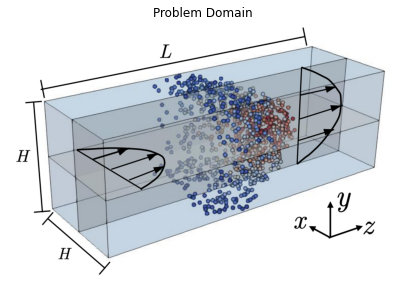

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# Output Images
plt.figure(figsize=(7,5))
plt.imshow(mpimg.imread("imgs/domain.png"))
plt.axis('off')
plt.title("Problem Domain")
plt.show()

In [8]:
#Analytical solution source: https://doi.org/10.1103/PhysRevE.71.057301

mu=0.001072 #Pa s
dp=-16.34957100885819 #pressure drop Pa

def eval_vel_sqrduct3D(x,y,z=None):
    #velocity is the same along axial direction of z
    V=0.0
    for i in range(20):
        n=(2*i+1)
        V+=1/n**3*(1-np.cosh(n*np.pi*x/h)/np.cosh(n*np.pi/2))*np.sin(n*np.pi*y/h)
        
    vz=-dp/L/mu*4*h*h/np.pi**3*V
    return vz

print("max velocity=",abs(eval_vel_sqrduct3D(0,h/2)),'cm/s')

max velocity= 22.47161576540229 cm/s


In [9]:
##https://www.jove.com/t/57205/the-diffusion-of-passive-tracers-in-laminar-shear-flow
print("Problem setup @ https://science.sciencemag.org/content/354/6317/1252")

# Length of the duct
L=100 #cm
# height of duct
h=0.1 #cm
# fluid viscosity
mu=0.001072 #Pa s
# pressure drop of square duct
dp=-16.34957100885819 #Pa
# dimension of the problem
Dim=3
# number of particles
NumOfParticles = 1000
# timestep for calculation, secs
timestep = 1e-2 
# total number of timestep
NumOfSteps = 50

#location and velocity of particles
pos = np.zeros([NumOfParticles,Dim],dtype=float)    
vel = np.zeros([NumOfParticles,Dim],dtype=float)    


def seedCube(cube_lower=[0.0,0.0,0.0],cube_size=[0.1,1.0,1.0]):
    #seeding particles within a cube
    for i in range(NumOfParticles):
        pos[i] = cube_lower + np.random.rand(Dim)*cube_size

Problem setup @ https://science.sciencemag.org/content/354/6317/1252


In [48]:
#check initial seeding
seedCube(cube_lower=[-h/2,0.0,0.0],cube_size=[h,h, 0.02])

#plot the particles
plot_pts=plot_particles(pos,world_bounds=[-h/2,0.0,0.0, h/2,h,L/300])

Output()

In [49]:
def advection(dt):
    #fluid driven advection
    
    #compute velocity using an analytical solution
    vz = eval_vel_sqrduct3D(pos[:,0],pos[:,1])
    vel[:,0],vel[:,1],vel[:,2] = 0.0, 0.0, vz

    for i in range(NumOfParticles):
        pos[i] += dt*vel[i]

def dispersion(dt,alphaL_coef,alphaT_coef):
    #randowm walk dispersion 
    for i in range(NumOfParticles):
        pos[i] += np.random.normal(0,1,Dim)#! B expression

# initlize particles wihtin a cube region 
seedCube(cube_lower=[-h/2,0.0,0.0],cube_size=[h,h, 0.02])

# main simulation loop
for i in range(NumOfSteps):
    #advection
    advection(dt=timestep)

    #dispersion
    dispersion(dt=timestep,diffusion_coef=5.7e-6)

    #animation by coloring particles using velocity
    if i%1==0:
        plot_pts.positions = pos
        plot_pts.attribute = vel[:,2]
        plot_pts.color_range=[0.0,0.12]
        clear_output(wait=True)
        time.sleep(0.1)
        print("Timestep=",i)

Timestep= 49
